# Часть 1. Инструменты

In [112]:
import osmnx as ox # основная библиотека для скачивания графа дорог и дальнейшей работы с ним
import networkx as nx # библиотека для работы с графом
import numpy as np # для работы с матрицами
import json # для записи некоторых данных было удобнее использовать json формат
import matplotlib.pyplot as plt # для визуализации графа
from geopy.geocoders import Nominatim # для получения гео-координат по адресу
from ortools.constraint_solver import routing_enums_pb2 # для решения задачи готовых алгоритмом
from ortools.constraint_solver import pywrapcp # для решения задачи готовых алгоритмом
from collections import OrderedDict 
from scipy import interpolate

# Часть 2. Сбор данных

In [ ]:
geolocator = Nominatim(user_agent="diploma-application")

def find_geo_coordinates(json1, json2):    
    with open(json1, 'r') as f:
        data = json.load(f)

    new_data = {}
    data_list = []
    i = 1
    for obj in data['results']:
        temp = {}
        address = "г. Улан-Удэ, " + obj['address']
        if type(obj['capacity']) != 'int':
            capacity = float(obj['count']) * float(obj['capacity'].replace(',', '.'))
        else:
            capacity = float(obj['count']) * float(obj['capacity'])
        location = geolocator.geocode(address)

        if location:
            temp['id'] = i
            temp['address'] = str(address)
            temp['lat'] = location.latitude
            temp['lon'] = location.longitude
            temp['capacity'] = capacity
            data_list.append(temp)
            i += 1

    new_data['results'] = data_list
    with open(json2, 'w') as f:
        json.dump(new_data, f, ensure_ascii=False)

find_geo_coordinates('data/oktyabr_json_file.json', 'data/oktyabr_geo.json')
find_geo_coordinates('data/zhelezn_json_file.json', 'data/zhelezn_geo.json')
find_geo_coordinates('data/sovet_json_file.json', 'data/sovet_geo.json')

In [9]:
i = 1
container_list = []

with open('data/sovet_geo.json', 'r') as f:
    data_for_containers = json.load(f)
for result in data_for_containers['results']:
    temp = {}
    temp['id'] = i
    temp['old_id'] = result['id']
    temp['coords'] = (result['lat'], result['lon'])
    temp['capacity'] = result['capacity']
    container_list.append(temp)
    i+=1
    
with open('data/oktyabr_geo.json', 'r') as f:
    data_for_containers = json.load(f)
for result in data_for_containers['results']:
    temp = {}
    temp['id'] = i
    temp['old_id'] = result['id']
    temp['coords'] = (result['lat'], result['lon'])
    temp['capacity'] = result['capacity']
    container_list.append(temp)
    i+=1
    
with open('data/zhelezn_geo.json', 'r') as f:
    data_for_containers = json.load(f)
for result in data_for_containers['results']:
    temp = {}
    temp['id'] = i
    temp['old_id'] = result['id']
    temp['coords'] = (result['lat'], result['lon'])
    temp['capacity'] = result['capacity']
    container_list.append(temp)
    i+=1

# Часть 3. Граф дорог

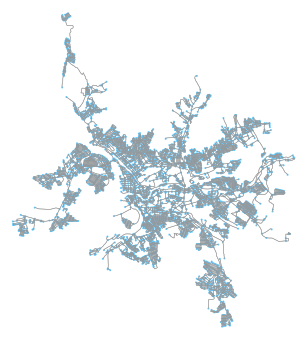

In [10]:
# скачиваем граф дорог города Улан-Удэ
place = {'city' : 'Ulan-Ude',
         'country' : 'Russia'}
G = ox.graph_from_place(place, network_type='drive')
fig, ax = ox.plot_graph(G, edge_linewidth=0.5, node_size=4)

In [12]:
# в скаченном графе уже содержится информация о расстоянии между смежными вершинами
# находим их и сохраняем в словарь следующего вида:
# {id узла} : {{id смежной с ним вершины} : расстояние между ними} 
a = G.adj
dictionary = {}
for key, value in a.items():
    for key_a, value_a in value.items():

        if key not in dictionary:
            dictionary[key] = [{key_a:value_a[0]['length']}]
        else:
            dictionary[key].append({key_a:value_a[0]['length']})

### Матрица смежности

In [13]:
nodes_list = list(G.nodes())
# она тоже нам дана уже в скаченном графе G
G_pd = nx.to_pandas_adjacency(G)
# из дата фрейма в привычный список списков
G_pd = G_pd.values

for i in range(len(G_pd)):
    for j in range(len(G_pd)):
        if G_pd[i][j] == 1:
            for k in range(len(dictionary[nodes_list[i]])):
                if nodes_list[j] in dictionary[nodes_list[i]][k].keys():
                    distance = dictionary[nodes_list[i]][k][nodes_list[j]]   
            G_pd[i][j] = distance
# здесь нужно где 0 заполнить гигантскими расстояниями для дальнейшего нахождения кратчайших путей
        if G_pd[i][j] == 0:
            G_pd[i][j] = 1000000

### Нахождение ближайших узлов

In [23]:
footprints_nodes = []
container_nodes_list = []
for container in container_list:
    container['node'] = ox.get_nearest_node(G, (container['coords'][0], container['coords'][1]))
    footprints_nodes.append([container['node']])
    container_nodes_list.append(container['node'])

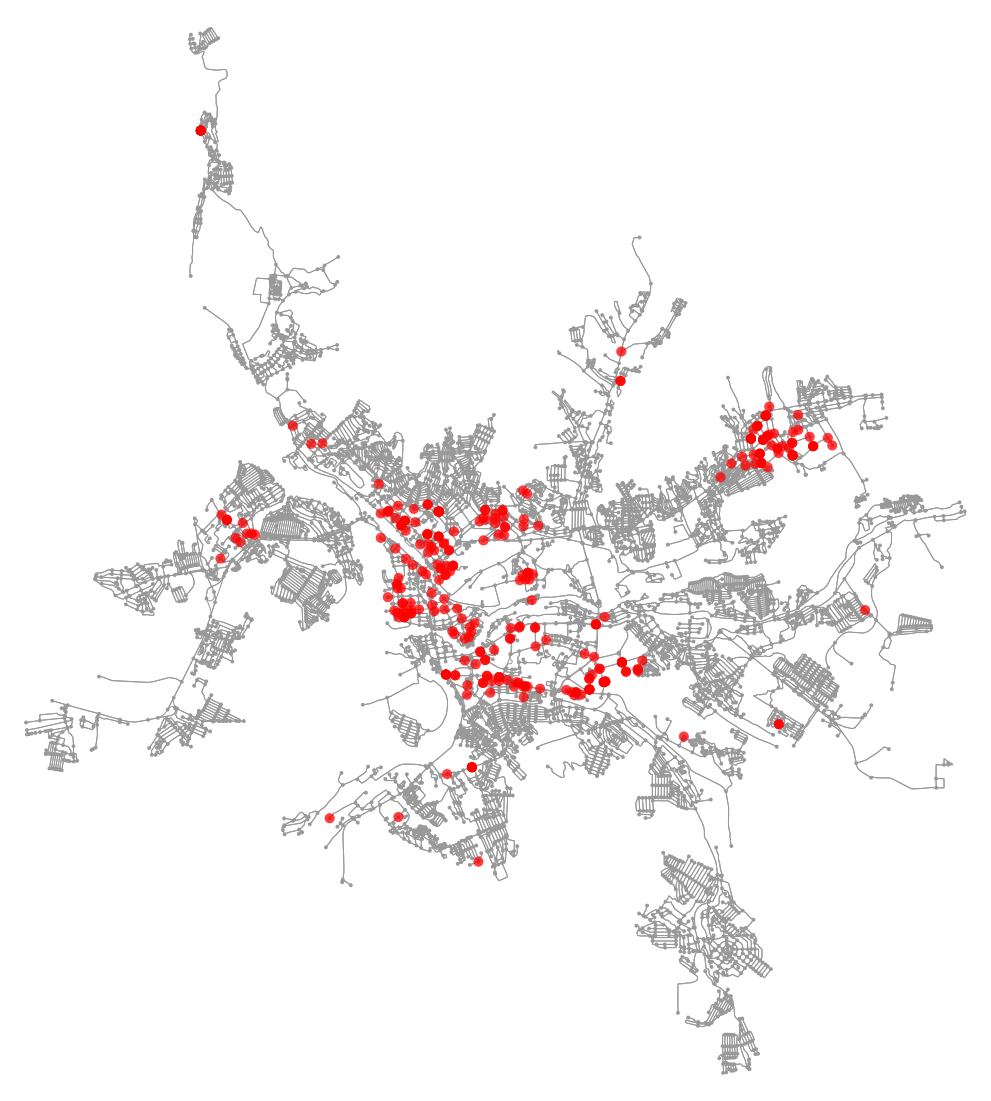

(<Figure size 1440x1440 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11f34ce20>)

In [21]:
ox.plot_graph_routes(G, footprints_nodes, fig_height=20, fig_width=20)

In [22]:
# извлекаем определенный процент равномерно распределенных элементов из списка площадок
from bisect import bisect_left

def equal_dist_els(my_list, fraction):
    """
    Chose a fraction of equally distributed elements.
    :param my_list: The list to draw from
    :param fraction: The ideal fraction of elements
    :return: Elements of the list with the best match
    """
    length = len(my_list)
    list_indexes = range(length)
    nbr_bins = int(round(length * fraction))
    step = length / float(nbr_bins)  # the size of a single bin
    bins = [step * i for i in range(nbr_bins)]  # list of bin ends
    # distribute indexes into the bins
    splits = [bisect_left(list_indexes, wall) for wall in bins]
    splits.append(length)  # add the end for the last bin
    # get a list of (start, stop) indexes for each bin
    bin_limits = [(splits[i], splits[i + 1]) for i in range(len(splits) - 1)]
    out = []
    for bin_lim in bin_limits:
        f, t = bin_lim
        in_bin = my_list[f:t]  # choose the elements in my_list belonging in this bin
        out.append(in_bin[int(0.5 * len(in_bin))])  # choose the most central element
    return out

### Пример: выбор 20 площадок

In [25]:
some_containers = equal_dist_els(container_nodes_list, 0.067)
print(len(some_containers))

20


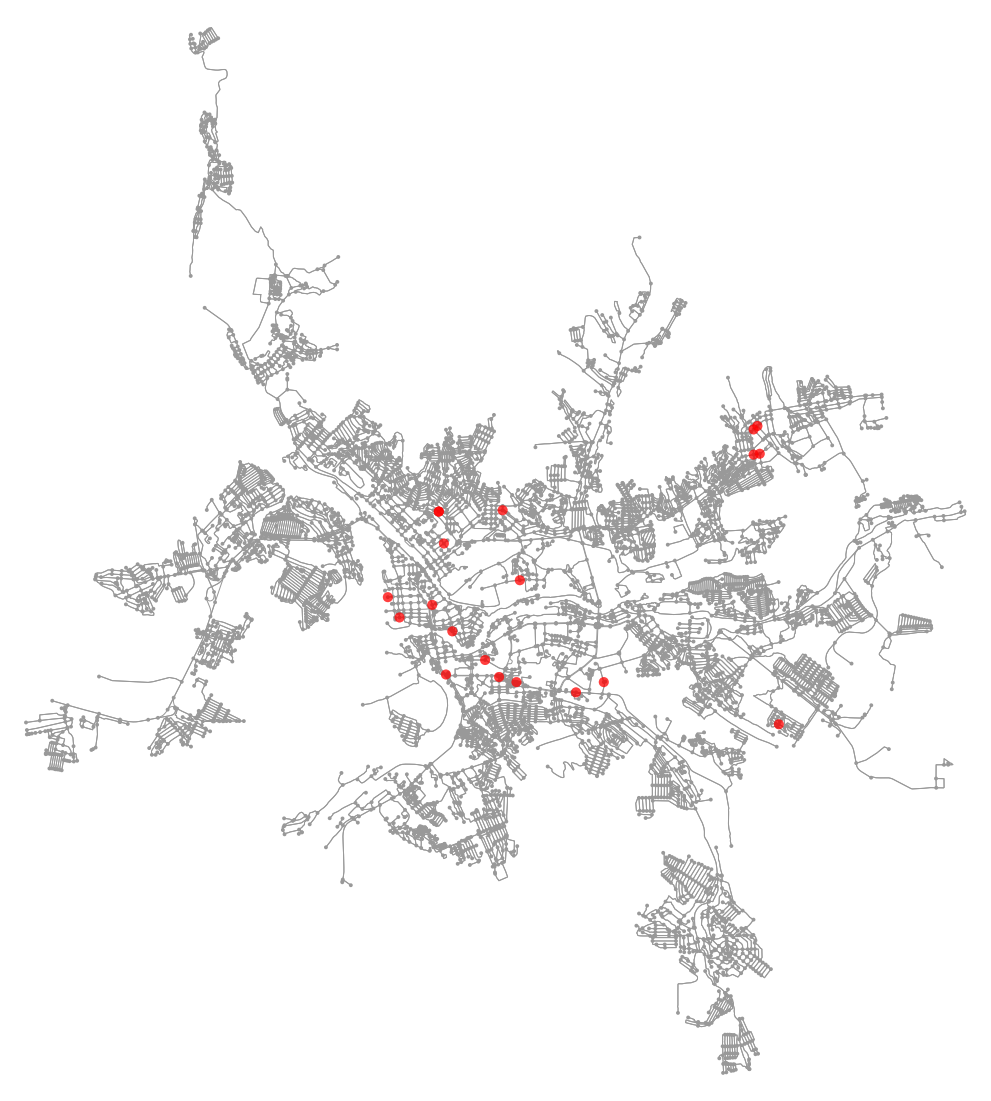

(<Figure size 1440x1440 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1216d50d0>)

In [30]:
footprints_nodes = []
for i in some_containers:
    footprints_nodes.append([i])
ox.plot_graph_routes(G, footprints_nodes, fig_height=20, fig_width=20)

In [31]:
# это делается для удобства, чтобы работать не с id узлами напрямую, а с их номером
nodes_numbers = {}
for index,i in enumerate(nodes_list):
    nodes_numbers[i]=index

### Нахождение матрицы кратчайших расстояний

In [32]:
num_containers = len(some_containers)
short_path_matrix = np.zeros((num_containers, num_containers))
routes = []
for i in range(num_containers):
    for j in range(num_containers):
        route = nx.shortest_path(G,
                         some_containers[i],
                         some_containers[j], 
                         weight='length')
        routes.append(route)
        shortest_path = 0
        for k in range(len(route)-1):
            shortest_path += G_pd[nodes_numbers[route[k]]][nodes_numbers[route[k+1]]]
        short_path_matrix[i][j] = shortest_path

## Выбираем стартовую и последнюю вершину

In [44]:
# для примера берем вершину 1 с индексом 0 и вершину 2 с индексом 1
start = 0
end = 1

In [46]:
# заполняем большим расстоянием нули
big_distance = 1000000
for i in range(num_containers):
    for j in range(num_containers):
        if short_path_matrix[i][j] == 0 and i!=j:
            short_path_matrix[i][j] = big_distance

short_path_matrix[start][end] = big_distance
            
for i in range(num_containers):
    if i != start and i != end:
        short_path_matrix[end][i] = big_distance
        short_path_matrix[i][start] = big_distance
# short_path_matrix  

# Часть 4. Подготовка данных

In [52]:
# подготовка данных
# добавляем новые узлы - концы
num_vehicles = 4
nodes_with_ends = some_containers.copy()
nodes_with_ends.extend([some_containers[end]] * (num_vehicles - 1))

### Расширяем матрицу расстояний

In [53]:
distance_matrix = np.zeros((len(nodes_with_ends), len(nodes_with_ends)))
for i in range(num_containers):
    for j in range(num_containers):
        distance_matrix[i][j] = short_path_matrix[i][j]       
        
for i in range(num_containers):
    for j in range(num_containers, num_containers):
        distance_matrix[i][j] = short_path_matrix[i][end]
        
for i in range(num_containers, num_containers):
    for j in range(num_containers):
        distance_matrix[i][j] = short_path_matrix[end][j]

for i in range(num_containers, num_containers):
    for j in range(num_containers, num_containers):
        if i != j:
            distance_matrix[i][j] = 1000000
        distance_matrix[end][j] = 1000000
        distance_matrix[i][end] = 1000000

# Часть 5. Разработка алгоритмов

## Алгоритм OR-Tools

In [54]:
# подготовка входных параметров
demands = []
for container_node in some_containers:
    for container in container_list:
        if container_node == container['node']:
            if len(demands) < num_containers:
                demands.append(container['capacity'])   
for i in range(num_containers, len(distance_matrix)):
    demands.append(0)

In [62]:
# подготовка входных параметров
data = {}
data['distance_matrix'] = distance_matrix.tolist()
data['vehicle_capacities'] = [14 for i in range(num_vehicles)]
data['num_vehicles'] = num_vehicles
data['depot'] = 0
additional_ends = [i for i in range(num_containers, num_containers + data['num_vehicles'])]
data['demands'] = demands
data['demands'][start] = 0
data['demands'][end] = 0

In [55]:
def main(data):
    """Solve the CVRP problem."""

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(
        demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.FromSeconds(1)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    paths_edges = []
    total_routes = []
    if solution:
        paths_edges, total_routes = print_solution(data, manager, routing, solution)
    else:
        print('no')
    return paths_edges, total_routes

In [67]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    total_distance = 0
    total_load = 0
    total_routes = []
    paths_edges = []
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        short_route = []
        short_route_index = []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            short_route.append(nodes_with_ends[node_index])
            short_route_index.append(node_index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) -> '.format(node_index, route_load)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),
                                                 route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}\n'.format(route_load)
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
        short_route_index.append(0)
        print(short_route_index)
        short_route.append(nodes_with_ends[0])
        print(short_route)
        
        path_edges = []
        for ind in range(len(short_route_index)-1):
            start_index = short_route_index[ind]
            end_index = short_route_index[ind+1]
            if short_route_index[ind] in additional_ends:
                start_index = end
            if short_route_index[ind+1] in additional_ends:
                end_index = end
            path_edges.append((start_index + 1, end_index + 1))
        paths_edges.append(path_edges)
        
        
        # to plot route in a map    
        long_route = []
        for r in range(len(short_route)-1):
            temp_route = nx.shortest_path(G,
                         short_route[r],
                         short_route[r+1], 
                         weight='length')
            long_route.extend(temp_route[:-1])
        total_routes.append(long_route)

        
    print('Total distance of all routes: {}m'.format(total_distance))
    print('Total load of all routes: {}'.format(total_load))
    print(len(total_routes))
    ox.plot_graph_routes(G, total_routes, route_color=['r', 'b', 'g', 'y'], fig_height=20, 
                         fig_width=20,  route_linewidth=4)
    
    return paths_edges, total_routes

### Решение встроенным алгоритмом и его визуализация на графе дорог

Route for vehicle 0:
 0 Load(0) ->  14 Load(0.75) ->  19 Load(2.25) ->  18 Load(4.25) ->  13 Load(6.5) ->  15 Load(7.25) ->  17 Load(14.0) ->  16 Load(17.0) ->  20 Load(17.0) ->  0 Load(17.0)
Distance of the route: 19523m
Load of the route: 17.0

[0, 14, 19, 18, 13, 15, 17, 16, 20, 0]
[976962146, 6338214884, 1214844443, 1315846461, 295080254, 1224344603, 1224284179, 1224284293, 5265196129, 976962146]
Route for vehicle 1:
 0 Load(0) ->  6 Load(4.0) ->  8 Load(7.75) ->  7 Load(10.0) ->  3 Load(11.4) ->  1 Load(11.4) ->  0 Load(11.4)
Distance of the route: 11278m
Load of the route: 11.4

[0, 6, 8, 7, 3, 1, 0]
[976962146, 492456329, 500015479, 5403854460, 1201608092, 5265196129, 976962146]
Route for vehicle 2:
 0 Load(0) ->  4 Load(1.0) ->  5 Load(7.0) ->  10 Load(10.0) ->  9 Load(13.0) ->  21 Load(13.0) ->  0 Load(13.0)
Distance of the route: 14736m
Load of the route: 13.0

[0, 4, 5, 10, 9, 21, 0]
[976962146, 6434875292, 864008754, 3793839623, 6004376692, 5265196129, 976962146]
Route for 

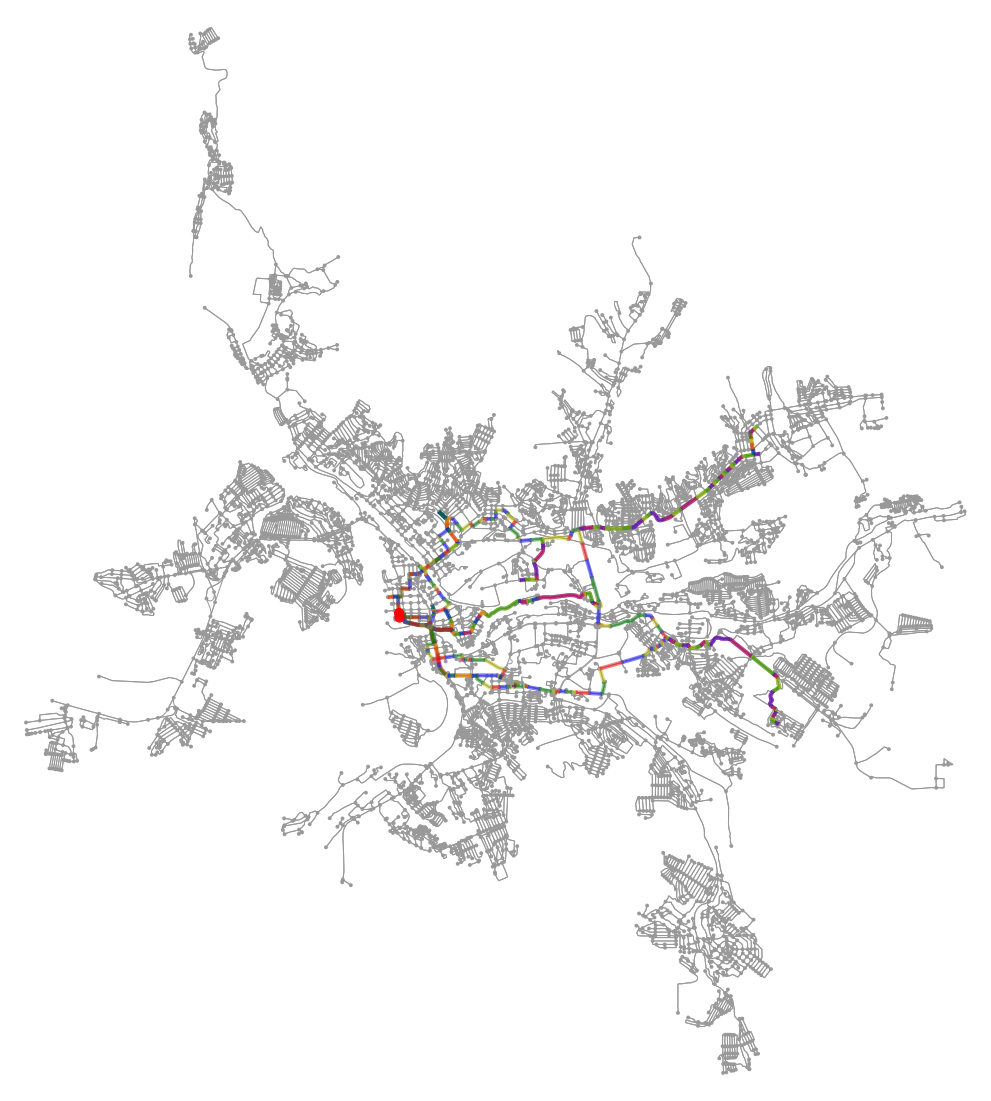

In [68]:
paths_edges, total_routes = main(data)

### Пример построения маршрута для одного ТС

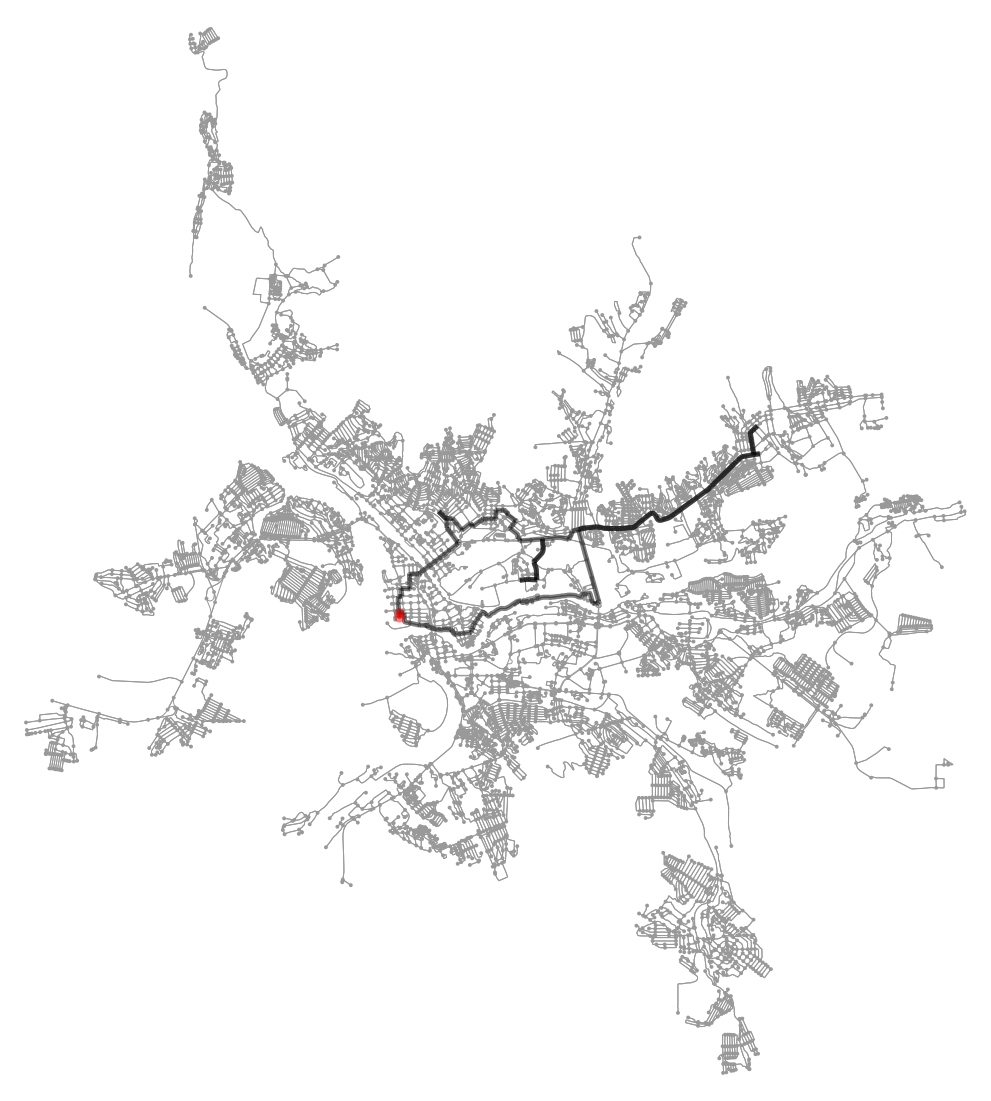

(<Figure size 1440x1440 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12262d910>)

In [69]:
ox.plot_graph_route(G, total_routes[0], route_color='k', fig_height=20, 
                    fig_width=20,  route_linewidth=5)

### Преобразование данных для визуализации графа

In [71]:
# graph to digraph
def graph_to_digraph(graph, n):
    di_G = nx.DiGraph()
    for i in range(n):
        for j in range(n):
            di_G.add_edge(i+1, j+1, weight=graph[i][j])
    return di_G  

di_G = graph_to_digraph(short_path_matrix, num_containers)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


<Figure size 30000x20000 with 0 Axes>

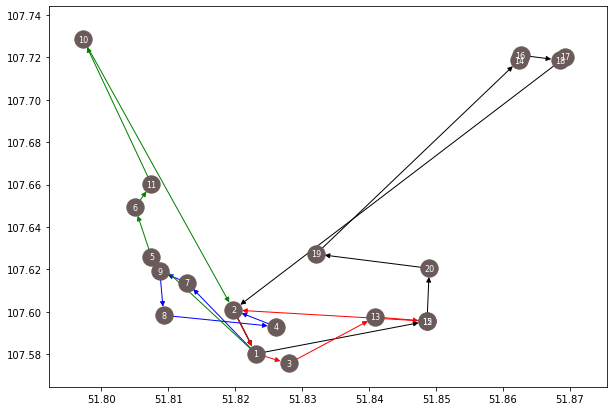

In [74]:
from collections import OrderedDict
node_coordinates = {}
for m in range(num_containers):
    node_coordinates[m+1] = (G.nodes[some_containers[m]]['y'], G.nodes[some_containers[m]]['x'])

colors = ['black', 'blue', 'green', 'red', 'pink', 'orange', 'purple']
plt.figure(dpi=5000)
_, ax = plt.subplots(figsize=(10,7))
pos = node_coordinates
nx.draw_networkx_nodes(di_G, pos=pos, ax=ax, node_color=(0.4157, 0.3529, 0.3490))
nx.draw_networkx_labels(G, pos=pos, labels={i: str(i) for i in range(1, num_containers + 1)}, font_size=8, font_color='white')
for i in range(len(paths_edges)):
    path = paths_edges[i]
    nx.draw_networkx_edges(G, pos=pos, edgelist=path, arrows=True, edge_color=colors[i%len(colors)])

ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

## ACO - Ant Colony Optimization (Муравьиный алгоритм)

In [87]:
import re
import math
import random
import numpy
from functools import reduce
import sys
import getopt

def generateGraph(matrix):
    edges = {}   
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            edges[(i+1, j+1)] = matrix[i][j]
            
    vertices = [i+1 for i in range(len(matrix))]

    feromones = {(min(a, b), max(a, b)): 1 for a in vertices for b in vertices if a != b}

    return vertices, edges, feromones


def solutionOfOneAnt(vertices, edges, capacityLimit, demand, feromones, alfa, beta):
    solution = list()

    while (len(vertices) != 1):
        path = list()
        city = numpy.random.choice(vertices[1:])
        capacity = capacityLimit - demand[city] - demand[end+1]
        path.append(city)
        vertices.remove(city)
        while (len(vertices) != 1):
            probabilities = list(map(lambda x: ((feromones[(min(x, city), max(x, city))]) ** alfa) * (
                        (1 / edges[(min(x, city), max(x, city))]) ** beta), vertices[1:]))
            probabilities = probabilities / numpy.sum(probabilities)

            city = numpy.random.choice(vertices[1:], p=probabilities)
            capacity = capacity - demand[city]

            if (capacity > 0):
                path.append(city)
                vertices.remove(city) 
            else:
                break
        path.append(end+1)
        solution.append(path)
    return solution

def x(x, alfa, beta):
    (feromones[(min(x, city), max(x, city))] ** alfa) * (
                        (1 / edges[(min(x, city), max(x, city))]) ** beta)


def rateSolution(solution, edges):
    s = 0
    for i in solution:
        s += edges[(start+1, i[0])]
        for j in range(len(i)-1):
            s = s + edges[(i[j], i[j+1])]
        a = 1
        for j in i:
            b = j
            s = s + edges[(min(a, b), max(a, b))]
            a = b
        b = 1
        s = s + edges[(min(a, b), max(a, b))]
        s += edges[(i[-1], start+1)]
    return s


def updateFeromone(feromones, solutions, bestSolution):
    Lavg = reduce(lambda x, y: x + y, (i[1] for i in solutions)) / len(solutions)
    feromones = {k: (ro + th / Lavg) * v for (k, v) in feromones.items()}
    solutions.sort(key=lambda x: x[1])
    if (bestSolution != None):
        if (solutions[0][1] < bestSolution[1]):
            bestSolution = solutions[0]
        for path in bestSolution[0]:
            for i in range(len(path) - 1):
                feromones[(min(path[i], path[i + 1]), max(path[i], path[i + 1]))] = sigm / bestSolution[1] + feromones[
                    (min(path[i], path[i + 1]), max(path[i], path[i + 1]))]
    else:
        bestSolution = solutions[0]
    for l in range(sigm):
        paths = solutions[l][0]
        L = solutions[l][1]
        for path in paths:
            for i in range(len(path) - 1):
                feromones[(min(path[i], path[i + 1]), max(path[i], path[i + 1]))] = (sigm - (l + 1) / L ** (l + 1)) + \
                                                                                    feromones[(
                                                                                    min(path[i], path[i + 1]),
                                                                                    max(path[i], path[i + 1]))]
    return bestSolution


def main_second(matrix, capacityLimit, demand, start=1, alfa, beta):
    bestSolution = None
    vertices, edges, feromones = generateGraph(matrix)
    vertices.remove(start)

#     print(vertices, edges, capacityLimit, demand, feromones)

    for i in range(iterations):
        solutions = list()
        for _ in range(ants):
            solution = solutionOfOneAnt(vertices.copy(), edges, capacityLimit, demand, feromones, alfa, beta)
            solutions.append((solution, rateSolution(solution, edges)))
        bestSolution = updateFeromone(feromones, solutions, bestSolution)
#         print(str(i) + ":\t" + str(int(bestSolution[1])))
    return bestSolution

### Преобразование входных параметров

In [116]:
short_path_matrix_2 = np.zeros((num_containers, num_containers))
for i in range(num_containers):
    for j in range(num_containers):
        short_path_matrix_2[i][j] = distance_matrix[i][j]
capacityLimit = data['vehicle_capacities'][0]

demand = {}
summa = 0
for i in range(1, len(short_path_matrix) + 1):
    demand[i] = data['demands'][i-1]
    summa += data['demands'][i-1]

In [117]:
alfa = 1.8
beta = 5
sigm = 3
ro = 0.8
th = 80
iterations = 100
ants = 30

### Подбор входных параметров

In [ ]:
for alfa in range(0, 2, 0.2):
    for beta in range(0, 5, 1):
        solutions = []
        total_r, total_s = main_second(short_path_matrix_2, capacityLimit, demand, start + 1, alfa, beta)
        solutions.append([alfa, beta, total_s])
min_solution = 1000000000000
for s in solutions:
    if s[2] < min_solution:
        min_solution = s[2]
        alfa = s[0]
        beta = s[1]
iterations = 1000

### Решение, построенное муравьиным алгоритмом

In [88]:
total_r, total_s = main_second(short_path_matrix_2, capacityLimit, demand, start + 1, alfa, beta)

In [89]:
total_r, total_s

([[9, 5, 7, 8, 4, 2],
  [17, 18, 14, 16, 2],
  [19, 20, 15, 13, 12, 2],
  [3, 6, 11, 10, 2]],
 91390.377)

### Преобразование маршрутов для построения графа

In [90]:
def routes_to_paths_edges(routes):
    paths_edges = []
    for r in routes:
        temp = [(start+1, r[0])]
        for i in range(len(r)-1):
            temp.append((r[i], r[i+1]))
        temp.append((r[-1], start+1))
        paths_edges.append(temp)
    return paths_edges

paths_edges = routes_to_paths_edges(total_r)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


<Figure size 6000x4000 with 0 Axes>

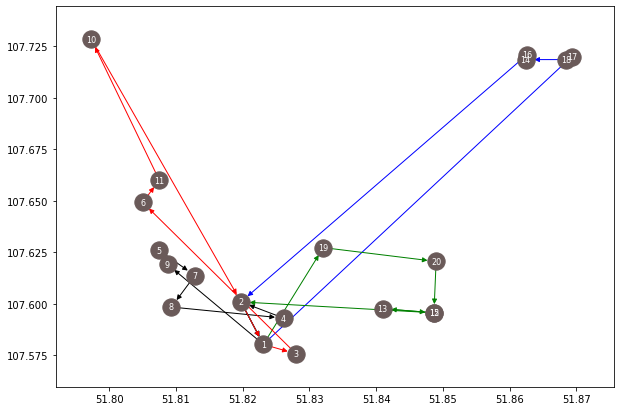

In [93]:
from collections import OrderedDict
node_coordinates = {}
for m in range(num_containers):
    node_coordinates[m+1] = (G.nodes[some_containers[m]]['y'], G.nodes[some_containers[m]]['x'])

colors = ['black', 'blue', 'green', 'red', 'pink', 'orange', 'purple']
plt.figure(dpi=1000)
_, ax = plt.subplots(figsize=(10,7))
pos = node_coordinates
nx.draw_networkx_nodes(di_G, pos=pos, ax=ax, node_color=(0.4157, 0.3529, 0.3490))
nx.draw_networkx_labels(G, pos=pos, labels={i: str(i) for i in range(1, num_containers + 1)}, font_size=8, font_color='white')
for i in range(len(paths_edges)):
    path = paths_edges[i]
    nx.draw_networkx_edges(G, pos=pos, edgelist=path, arrows=True, edge_color=colors[i%len(colors)])

ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

## Преобразование маршрутов для построения графа дорог

In [96]:
def paths_index_to_nodes(r):
    temp_r = [some_containers[start]]
    for i in r:
        temp_r.append(some_containers[i-1])
    temp_r.append(some_containers[start])
        
    long_route = []
    for j in range(len(temp_r)-1):
        temp_route = nx.shortest_path(G,
                         temp_r[j],
                         temp_r[j+1], 
                         weight='length')
        long_route.extend(temp_route[:-1])
    return long_route

new_total_r = []
for r in total_r:
    new_total_r.append(paths_index_to_nodes(r))

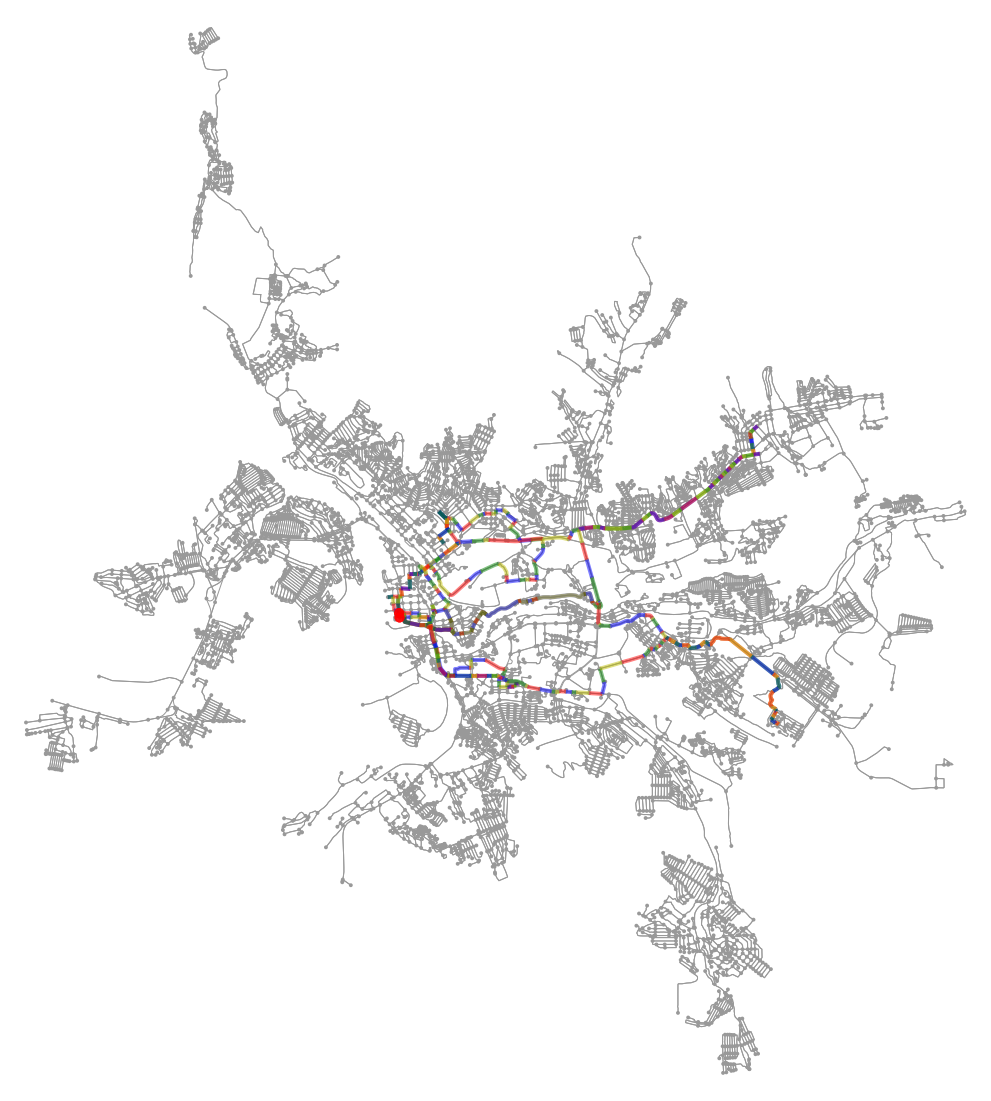

(<Figure size 1440x1440 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x119cdb970>)

In [97]:
ox.plot_graph_routes(G, new_total_r, route_color=['r', 'b', 'g', 'y'], fig_height=20, 
                     fig_width=20,  route_linewidth=4)

## Genetic Algorithm (Генетический алгоритм)

In [98]:
node_coordinates = {}
for m in range(len(some_containers)):
    node_coordinates[m+1] = (G.nodes[some_containers[m]]['y'], G.nodes[some_containers[m]]['x'])

### Подготовка входных параметров и запись их в файл

In [114]:
# coordinates of the nodes
coords = [(-1, -1)]
for i in node_coordinates.keys():
    coords.append(node_coordinates[i])

# demand list like [-1, 0, 5, 2, 7, 2, 1 ...]
demand_list = [-1]
for k in data['demands']:
    demand_list.append(k)

# short_path_matrix_2 with zeros on the diagonal
b = short_path_matrix_2.tolist()
a = {'matrix':b, 
     'coords': coords, 
     'demand': demand_list, 
     'dimension': len(some_containers),
     'capacity': capacityLimit}

with open('GA/data_new.json','w') as f:
    json.dump(a,f)

In [102]:
with open('GA/solution_ga.json', 'r') as f:
    solution = json.load(f)
solution

{'cost': 90529.763,
 'routes': [[1, 3, 4, 7, 9, 8, 2, 1],
  [1, 19, 20, 12, 13, 15, 2, 1],
  [1, 5, 6, 11, 10, 2, 1],
  [1, 17, 18, 16, 14, 2, 1]]}

### Преобразование маршрутов для построение графа дорог

In [104]:
def paths_index_to_nodes_2(r):
    temp_r = []
    for i in r:
        temp_r.append(some_containers[i-1])
        
    long_route = []
    for j in range(len(temp_r)-1):
        temp_route = nx.shortest_path(G,
                         temp_r[j],
                         temp_r[j+1], 
                         weight='length')
        long_route.extend(temp_route[:-1])
    return long_route

new_total_r = []
for r in solution['routes']:
    new_total_r.append(paths_index_to_nodes_2(r))

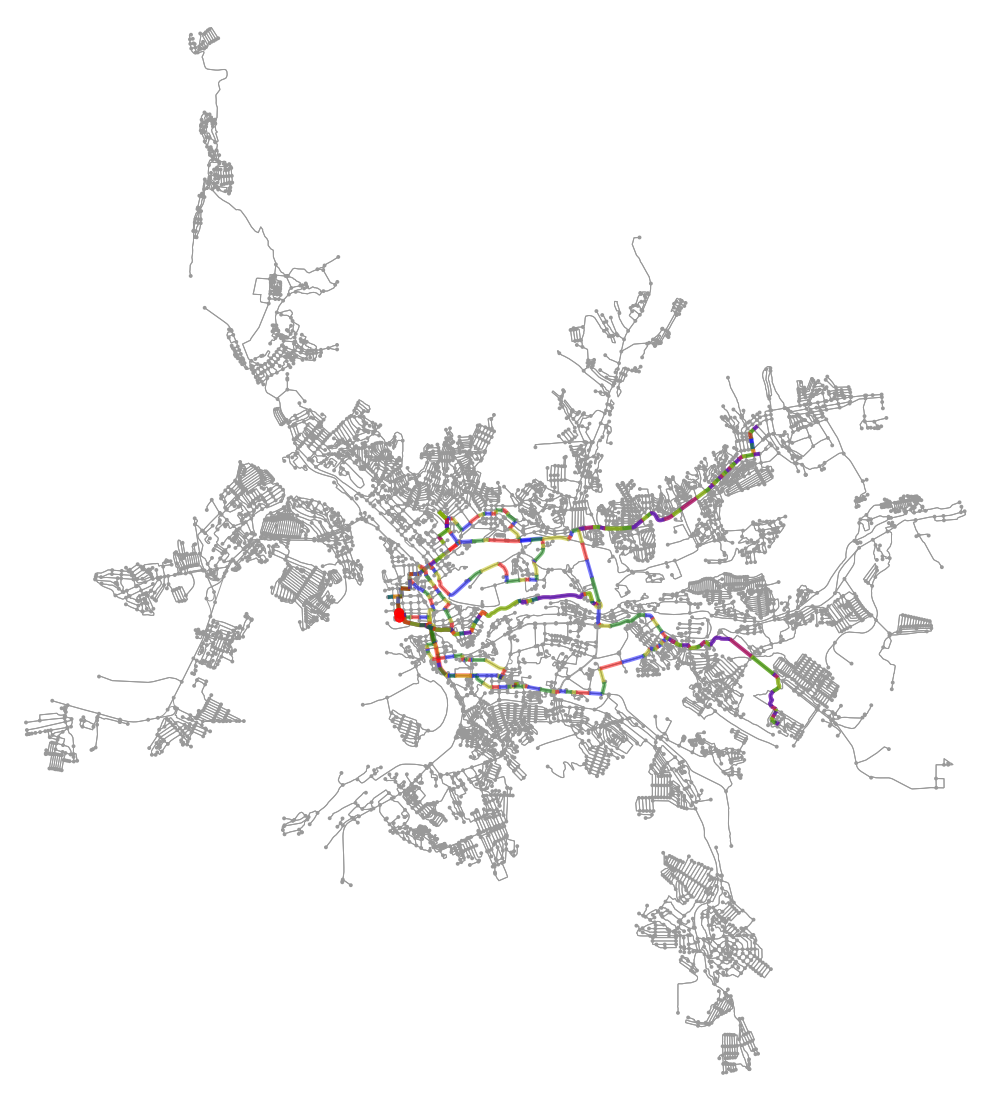

(<Figure size 1440x1440 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11ca761f0>)

In [105]:
ox.plot_graph_routes(G, new_total_r, route_color=['r', 'b', 'g', 'y'], fig_height=20, 
                         fig_width=20,  route_linewidth=4)

### Преобразование маршрутов для построение графа

In [106]:
def routes_to_paths_edges(routes):
    paths_edges = []
    for r in routes:
        temp = []
        for i in range(len(r)-1):
            temp.append((r[i], r[i+1]))
        paths_edges.append(temp)
    return paths_edges

paths_edges = routes_to_paths_edges(solution['routes'])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


<Figure size 6000x4000 with 0 Axes>

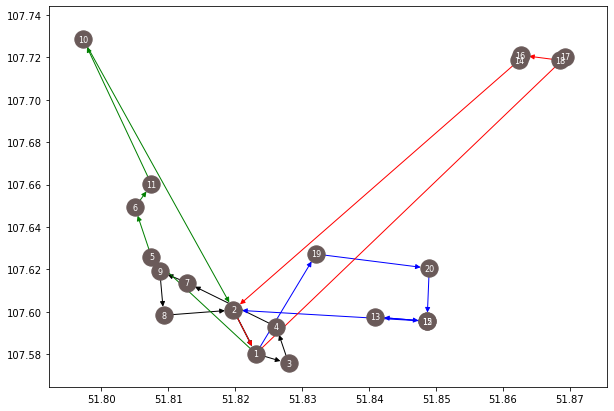

In [110]:
node_coordinates = {}
for m in range(len(some_containers)):
    node_coordinates[m+1] = (G.nodes[some_containers[m]]['y'], G.nodes[some_containers[m]]['x'])

colors = ['black', 'blue', 'green', 'red', 'pink', 'orange', 'purple']
plt.figure(dpi=1000)
_, ax = plt.subplots(figsize=(10,7))
pos = node_coordinates
nx.draw_networkx_nodes(di_G, pos=pos, ax=ax, node_color=(0.4157, 0.3529, 0.3490))
nx.draw_networkx_labels(G, pos=pos, labels={i: str(i) for i in range(1, len(some_containers) + 1)}, font_size=8, font_color='white')
for i in range(len(paths_edges)):
    path = paths_edges[i]
    nx.draw_networkx_edges(G, pos=pos, edgelist=path, arrows=True, edge_color=colors[i%len(colors)])

ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

### Пример построения маршрута для одного ТС

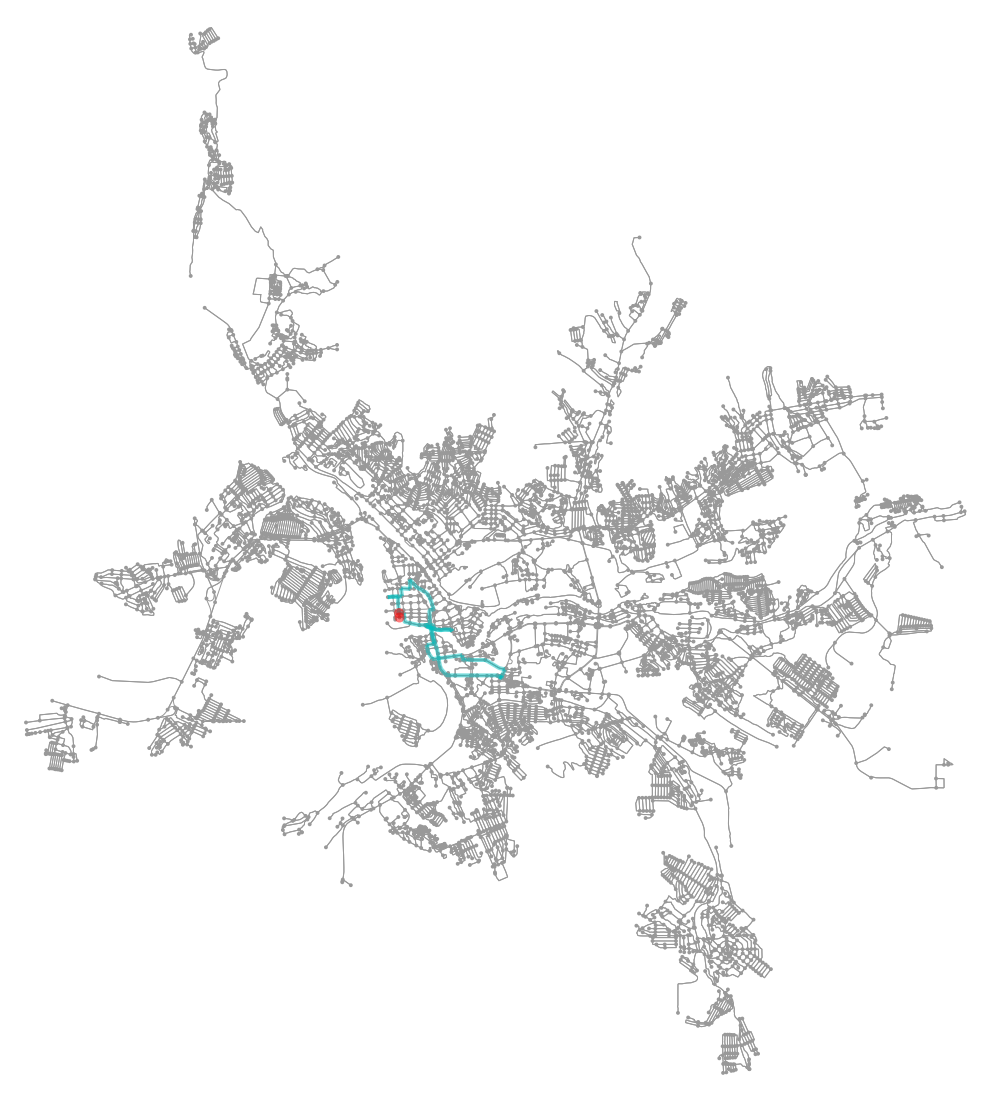

(<Figure size 1440x1440 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12030bd60>)

In [111]:
ox.plot_graph_route(G, new_total_r[0], route_color='c', fig_height=20, 
                    fig_width=20,  route_linewidth=4)

# Часть 6. Сравнение результатов

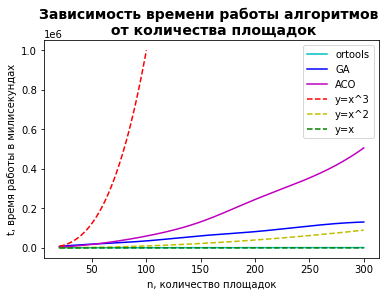

In [113]:
x_points = np.array([20, 50, 100, 150, 200, 250, 300])
y_points = np.array([942, 966, 977, 1020, 1200, 1500, 1700])

tck = interpolate.splrep(x_points, y_points)

x = np.linspace(20, 300, 600)
y = interpolate.splev(x, tck)

x1_points = np.array([20, 50, 100, 150, 200, 250, 300])
y1_points = np.array([7672, 19159, 35490, 61230, 82324, 110699, 131000])

tck1 = interpolate.splrep(x1_points, y1_points)

x1 = np.linspace(20, 300, 600)
y1 = interpolate.splev(x1, tck1)

x2_points = np.array([20, 50, 100, 150, 200, 250, 300])
y2_points = np.array([3980, 17800, 60000, 132000, 245000, 354000, 506000])

tck2 = interpolate.splrep(x2_points, y2_points)

x2 = np.linspace(20, 300, 600)
y2 = interpolate.splev(x2, tck2)


x3 = np.linspace(20, 100, 100)
y3 = x3**3


x4 = np.linspace(20, 300, 100)
y4 = x4**2

x5 = np.linspace(20, 300, 100)
y5 = x5

ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.plot(x, y, 'c', label='ortools')
plt.plot(x1, y1, 'b', label='GA') 
plt.plot(x2, y2, 'm', label='ACO') 
plt.plot(x3, y3, '--r', label='y=x^3')
plt.plot(x4, y4, '--y', label='y=x^2')
plt.plot(x5, y5, '--g', label='y=x')
plt.title("Зависимость времени работы алгоритмов \n от количества площадок", fontsize=14, fontweight="bold")
plt.xlabel("n, количество площадок")
plt.ylabel("t, время работы в милисекундах")
plt.legend(loc='upper right')
plt.show()